# 🤖 Modelado Supervisado H2O + GPU + Paralelo - Precios Inmobiliarios Dinamarca

**Objetivo**: Construir modelos distribuidos H2O, clásicos sklearn y de árbol con optimizaciones GPU y paralelización, evaluarlos con métricas sólidas considerando rendimiento y velocidad.

1. División de Datos (Temporal)

    1.1 Split temporal (80% train, 20% test)

    1.2 Validación de distribución en train/test

    1.3 Visualización de drift o cambios en el tiempo (si aplica)

2. Modelos Estadísticos

    2.1 Regresión Lineal, Ridge, Lasso, ElasticNet

    2.2 Ajuste con mínimos cuadrados o likelihood

    2.3 Comparación de modelos con AIC/BIC (sin CV)

    2.4 Diagnóstico de residuos y detección de outliers

3. Modelos de Árboles

    3.1 LightGBM y Random Forest (hiperparámetros por defecto o mínimos)

    3.2 Comparación con modelos estadísticos

    3.3 Feature importance y explicabilidad inicial

6. Evaluación General

    6.1 Métricas: RMSE, MAE, MAPE, R²

    6.2 Visualización de errores (residuos, pred vs real)

    6.3 Análisis por segmentos (tipo de casa, región)

    6.4 Tabla resumen de modelos y conclusiones

## Requistos previos

```
feature_engineered_complete.parquet, modeling_dataset.parquet, train_data.parquet, test_data.parquet

scalers.pkl, selected_features.txt
```

Obtener los datos de `04_feature_engineering.ipynb` 

In [ ]:
from setup import set_project_root
set_project_root()

from config import *
from descriptive_analysis import (
    load_and_validate_data,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings




## 1. División de Datos (Temporal)

### 1.1 Split temporal (80% train, 20% test)

Se cargan los datos generados en la extracción de características.

In [ ]:
import h2o 
from h2o.estimators import H2OXGBoostEstimator
from joblib import load
import pandas as pd


In [ ]:

# 🚀 Iniciar H2O
h2o.init()


In [ ]:

# 📦 Cargar datos en pandas y escalar
train = pd.read_parquet(TRAIN_DATA_FILE)
test = pd.read_parquet(TEST_DATA_FILE)

features = open(SELECTED_FEATURES_FILE).read().splitlines()
scalers = load(SCALERS_FILE)


In [ ]:
train.describe()


In [ ]:
test.describe()

In [ ]:
# grafico comparativo de la variable temporal
plt.plot(train['year'], label="Train")
plt.plot(test['year'], label="Test")

## anadir una linea horizonalt en el 2017
plt.axhline(y=2017, color='r', linestyle='--', label='Año de corte')
plt.text(2017, 2018, '2017', color='black', fontsize=12)
plt.legend()
plt.title("Distribución Temporal")
plt.show()

Validamos que nuestro dataset cumpla con las condiciones de tiempo y que no haya fugas de datos entre train y test.


In [ ]:
sns.kdeplot(train['log_price'], label='Train')
sns.kdeplot(test['log_price'], label='Test')
plt.title("Distribución de Precios")
plt.legend()
plt.show()


In [ ]:
import optuna
import h2o
import pandas as pd
from joblib import load, dump
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from functools import partial
from h2o.estimators import H2OXGBoostEstimator


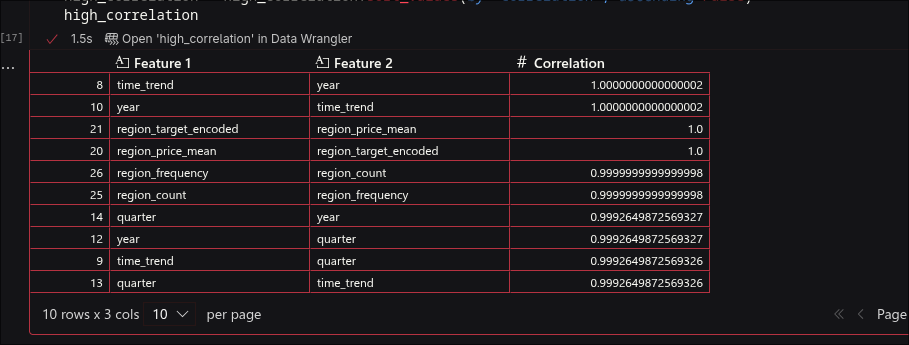

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 🔧 FUNCIONES
def load_scaled_data(target=TARGET):
    # 1. Cargar features seleccionados
    selected_features = open(SELECTED_FEATURES_FILE).read().splitlines()
    
    exclude_features = [TARGET, "quarter", "region_count", "price_deviation_from_median", "time_trend", "region_target_encoded", "region_count"]
    
    selected_features = [f for f in selected_features if f not in exclude_features]

    # 2. Cargar datasets
    train = pd.read_parquet(TRAIN_DATA_FILE)
    test = pd.read_parquet(TEST_DATA_FILE)

    # 3. Separar X e y
    
    
    X_train_raw = train[selected_features]
    X_test_raw = test[selected_features]
    
    y_train = train[target].reset_index(drop=True)
    y_test = test[target].reset_index(drop=True)

    # 4. Escalar X con StandardScaler
    scaler = StandardScaler().fit(X_train_raw)
    X_train = pd.DataFrame(scaler.transform(X_train_raw), columns=selected_features)
    X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=selected_features)
    
    if TARGET in X_train.columns:
        X_train = X_train.drop(columns=[TARGET])
        X_test = X_test.drop(columns=[TARGET])


    return X_train, X_test, y_train, y_test, selected_features, scaler


In [ ]:
# 📦 CARGAR DATA
X_train, X_test, y_train, y_test, features, scaler = load_scaled_data(target=TARGET)


In [ ]:
X_train.corr()

In [ ]:

sns.heatmap(X_train.corr(), annot=False, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8})


In [ ]:
#obtener las mas altas correlaciones
correlation_matrix = X_train.corr()
high_correlation = correlation_matrix[abs(correlation_matrix) > 0.8].stack().reset_index()
high_correlation.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation = high_correlation[high_correlation['Feature 1'] != high_correlation['Feature 2']]
high_correlation = high_correlation.sort_values(by='Correlation', ascending=False)

if high_correlation.empty:
    print("No hay correlaciones altas (>0.8) entre las variables.")
else:
    print("Correlaciones altas (>0.8) entre las variables:")
    print(high_correlation)

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

train_h2o = h2o.H2OFrame(df_train)
test_h2o = h2o.H2OFrame(df_test)


In [ ]:

train_h2o[TARGET] = train_h2o[TARGET].asnumeric()
test_h2o[TARGET] = test_h2o[TARGET].asnumeric()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial, features, target, train_h2o, test_h2o):
    params = {
        "ntrees": trial.suggest_int("ntrees", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learn_rate": trial.suggest_float("learn_rate", 0.01, 0.2),
        "col_sample_rate": trial.suggest_float("col_sample_rate", 0.6, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_rows": trial.suggest_int("min_rows", 1, 10),
        "backend": "gpu",  
        "seed": 42
    }

    model = H2OXGBoostEstimator(**params)
    model.train(x=features, y=target, training_frame=train_h2o)

    preds = model.predict(test_h2o).as_data_frame().values.ravel()
    true = test_h2o[target].as_data_frame().values.ravel()
    


    rmse = np.sqrt(mean_squared_error(true, preds))
    return rmse

    

# ⛓️ WRAP con partial
objective_fn = partial(
    objective,
    features=features,
    target=TARGET,
    train_h2o=train_h2o,
    test_h2o=test_h2o
)



In [ ]:

study_name = "h2o_xgb_gpu_tuning2"
storage_url = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    storage=storage_url,
    load_if_exists=True
)

study.optimize(objective_fn, n_trials=10)

print("✅ Best trial:")
print(study.best_trial.params)

In [ ]:
study.best_trial.params

In [ ]:
best_params = study.best_trial.params
best_model = H2OXGBoostEstimator(**best_params)
best_model.train(x=features, y=TARGET, training_frame=train_h2o)
best_model_path = best_model.save_mojo(path="models/", force=True)
print(f"📦 Modelo guardado en: {best_model_path}")


In [ ]:
from optuna.visualization.matplotlib import plot_param_importances, plot_optimization_history
import matplotlib.pyplot as plt

plot_param_importances(study)
plt.show()

plot_optimization_history(study)
plt.show()


In [ ]:
evaluation = best_model.model_performance(test_data=test_h2o)
print("RMSE en test:", evaluation.rmse())

In [ ]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(
    max_runtime_secs=600,           # ⏱️ tiempo total (ajustá según tu disponibilidad)
    seed=42,
    include_algos=["XGBoost"],      # ⚡ Solo modelos con soporte GPU
    sort_metric="RMSE",            # O 'MAE', 'R2', etc.
    keep_cross_validation_predictions=True
)

aml.train(x=features, y=TARGET, training_frame=train_h2o)


In [ ]:
# Evaluar en test_h2o
perf_automl = aml.leader.model_performance(test_h2o)
print("🔍 AutoML RMSE:", perf_automl.rmse())

# Comparar con Optuna-tuneado
perf_optuna = best_model.model_performance(test_h2o)
print("🎯 Optuna RMSE:", perf_optuna.rmse())



In [ ]:
# ==================================================
# 📊 EVALUACIÓN COMPRENSIVA DE MODELOS
# ==================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calculate_mape(y_true, y_pred):
    """Calcula MAPE evitando división por cero"""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(model, test_h2o, model_name):
    """Evalúa un modelo H2O y retorna métricas"""
    # Predicciones
    preds = model.predict(test_h2o).as_data_frame().values.ravel()
    true = test_h2o[TARGET].as_data_frame().values.ravel()
    
    # Métricas
    rmse = np.sqrt(mean_squared_error(true, preds))
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    mape = calculate_mape(true, preds)
    
    return {
        'Modelo': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'Predicciones': preds,
        'Reales': true
    }

# Evaluar ambos modelos
results = []
results.append(evaluate_model(best_model, test_h2o, "XGBoost Optuna"))
results.append(evaluate_model(aml.leader, test_h2o, "AutoML Leader"))

print("✅ Evaluación completada")

In [ ]:
# ==================================================
# 📈 TABLA COMPARATIVA Y VISUALIZACIONES
# ==================================================

# Crear tabla comparativa
comparison_df = pd.DataFrame(results)[['Modelo', 'RMSE', 'MAE', 'R²', 'MAPE (%)']]
comparison_df = comparison_df.round(4)

print("🏆 COMPARACIÓN DE MODELOS:")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Identificar mejor modelo
best_idx = comparison_df['RMSE'].idxmin()
best_model_name = comparison_df.iloc[best_idx]['Modelo']
print(f"\n🥇 Mejor modelo: {best_model_name}")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicciones vs Reales
for i, result in enumerate(results):
    axes[0, 0].scatter(result['Reales'], result['Predicciones'], 
                      alpha=0.6, label=result['Modelo'], s=1)
axes[0, 0].plot([min(results[0]['Reales']), max(results[0]['Reales'])], 
                [min(results[0]['Reales']), max(results[0]['Reales'])], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Predicciones')
axes[0, 0].set_title('Predicciones vs Valores Reales')
axes[0, 0].legend()

# 2. Distribución de Residuos
for i, result in enumerate(results):
    residuals = result['Reales'] - result['Predicciones']
    axes[0, 1].hist(residuals, bins=50, alpha=0.7, label=result['Modelo'], density=True)
axes[0, 1].set_xlabel('Residuos')
axes[0, 1].set_ylabel('Densidad')
axes[0, 1].set_title('Distribución de Residuos')
axes[0, 1].legend()

# 3. Métricas comparativas
metrics = ['RMSE', 'MAE', 'R²', 'MAPE (%)']
x_pos = np.arange(len(metrics))
width = 0.35

for i, result in enumerate(results):
    values = [comparison_df.iloc[i]['RMSE'], comparison_df.iloc[i]['MAE'], 
              comparison_df.iloc[i]['R²'], comparison_df.iloc[i]['MAPE (%)']]
    axes[1, 0].bar(x_pos + i*width, values, width, label=result['Modelo'])

axes[1, 0].set_xlabel('Métricas')
axes[1, 0].set_ylabel('Valores')
axes[1, 0].set_title('Comparación de Métricas')
axes[1, 0].set_xticks(x_pos + width/2)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].legend()

# 4. Residuos vs Predicciones
for i, result in enumerate(results):
    residuals = result['Reales'] - result['Predicciones']
    axes[1, 1].scatter(result['Predicciones'], residuals, 
                      alpha=0.6, label=result['Modelo'], s=1)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Predicciones')
axes[1, 1].set_ylabel('Residuos')
axes[1, 1].set_title('Residuos vs Predicciones')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# ==================================================
# 🎯 ANÁLISIS DE IMPORTANCIA Y RESUMEN FINAL
# ==================================================

# Feature Importance del mejor modelo
print("🔍 IMPORTANCIA DE VARIABLES:")
print("=" * 40)

# Obtener importancia de variables
varimp = best_model.varimp(use_pandas=True)
top_features = varimp.head(10)

print(top_features.to_string(index=False))

# Visualizar importancia
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['scaled_importance'])
plt.yticks(range(len(top_features)), top_features['variable'])
plt.xlabel('Importancia Relativa')
plt.title('Top 10 Variables Más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Guardar resultados
results_summary = {
    'best_model': best_model_name,
    'metrics': comparison_df.to_dict('records'),
    'feature_importance': top_features.to_dict('records'),
    'total_test_samples': len(results[0]['Reales'])
}

# Guardar en archivo
import json
with open('results/model_evaluation_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n💾 Resultados guardados en: results/model_evaluation_summary.json")
print(f"📊 Muestras evaluadas: {results_summary['total_test_samples']:,}")
print("✅ Evaluación completa finalizada")